## Table of Contents

- [1. Data Extraction](#etl)
- [2. Data Preprocessing](#dpp)
    - [2.1 Missing Data](#null)
    - [2.2 Duplicate Data](#dupe)
    - [2.3 Feature Engineering](#feature)
    - [2.4 Data Splitting](#split)
- [3. Model Training](#train)
    - [3.1 Logistic Regression](#lr)
    - [3.2 Decision Tree](#dt)
    - [3.3 Random Forest](#rf)
    - [3.4 Threshold](#threshold)
    - [3.5 Upsample](#upsample)
    - [3.6 Downsample](#downsample)
    - [3.6 Tomek's Links](#tomek)
    - [3.6 SMOTE](#smote)
- [4. Parameter Hypertuning](#pht)
- [5. Model Testing](#test)
    - [5.1 Sanity Check](#sanity)
- [Conclusion](#end)

### 1. Data Extraction <a class="anchor" id="etl"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks

from IPython.display import display

try:
    df = pd.read_csv('../datasets/Churn.csv')
    display(df.sample(5))
except:
    print("Data not found")



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4300,4301,15633834,Milne,700,Germany,Female,28,3.0,99705.69,2,0,0,146723.72,0
8056,8057,15736078,Ting,730,Germany,Female,33,7.0,130367.87,1,1,0,15142.10,1
9136,9137,15688984,Belonwu,595,France,Male,20,4.0,95830.43,1,1,0,177738.98,0
5743,5744,15571476,Kelly,635,Spain,Male,38,0.0,103257.14,1,0,0,158344.63,0
3188,3189,15586757,Anenechukwu,801,France,Female,32,4.0,75170.54,1,1,1,37898.50,0


Data is customers and their personal/banking information. 
RowNumber is redundant column, and surname/customerid are not logical choices as a features for the model. Also, gender and geography need encoding because they are strings.

In [2]:
# dropping columns that won't be used in features
df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)

def camel_to_snake(name):
  name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
  return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

for column in df.columns:
    df = df.rename(columns={column:camel_to_snake(column)})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


All datatypes are correct. Missing tenure values need to be investigated.

### 2. Data preprocessing <a class="anchor" id="dpp"></a>

#### 2.1 Missing Data <a class="anchor" id="null"></a>

In [3]:
print(df['tenure'].value_counts())
df[df['tenure'].isna()].head()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Even though there are far fewer rows with 0.0 tenure, this missing data could mean many things as there are missing values from customers that have exited and haven't. We need to verify. Simply dropping these rows will remove less than 10% of data so will drop for now.

#### 2.2 Duplicate Data <a class="anchor" id="dupe"></a>

In [4]:
df[df.duplicated() == True].count()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [5]:
# drop missing values
df.dropna(inplace=True)
df.count()

credit_score        9091
geography           9091
gender              9091
age                 9091
tenure              9091
balance             9091
num_of_products     9091
has_cr_card         9091
is_active_member    9091
estimated_salary    9091
exited              9091
dtype: int64

The data has been imported cleanly for feature preparation and model training. Missing data rows need to be investigated further

#### 2.3 Feature Preparation <a class="anchor" id="feature"></a>

Now for encoding the geography and gender:

In [6]:
# drop on the first dummy columns because the high correlation will confuse our model
df_ohe = pd.get_dummies(df,drop_first=True)
# column names converted to lowercase
df_ohe.columns = df_ohe.columns.str.lower()
df_ohe.sample(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
5332,710,29,3.0,119670.18,1,1,0,188022.44,0,0,1,0
6791,600,39,7.0,88477.36,2,1,0,58632.37,0,1,0,0
5461,531,31,2.0,118899.45,2,0,0,41409.36,0,0,1,1
380,483,50,9.0,0.00,2,1,1,111020.24,0,0,0,0
4396,721,68,4.0,136525.99,1,0,0,175399.14,0,1,0,1


#### 2.4 Data splitting <a class="anchor" id="split"></a>

A common ratio, that I will use, for splitting raw data into training, validation, and test data is 3:1:1. The target will be the 'Exited' column because we want to predict if customers will exit. This is a binary target so we will need a classifier model.

In [7]:
# split data into training, validation, and testing 
df_train, df_valid_test = train_test_split(df_ohe, test_size=0.4,random_state=12345)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5,random_state=12345)

# Declare variables for the features and target of split data.
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

print("Size of training dataset:",len(df_train))
print("Size of validation dataset:",len(df_valid))
print("Size of testing dataset:",len(df_test))

Size of training dataset: 5454
Size of validation dataset: 1818
Size of testing dataset: 1819


I will also standardize all the numerical columns in each data split (with standardizer fit to training data) so that dispersion will have less effect on classes.

In [8]:
numeric = ['credit_score','age','balance','num_of_products','estimated_salary','tenure']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_train[numeric].sample(5)

,credit_score,age,balance,num_of_products,estimated_salary,tenure
9962,0.550971,0.466548,-1.237830,-0.908179,-0.707422,1.385532
1994,0.581944,0.937133,-1.237830,-0.908179,-0.635157,0.696524
9394,-0.533068,-0.380507,0.879594,-0.908179,1.593293,1.041028
4583,-0.254315,-0.098155,-1.237830,0.809300,-0.084305,1.041028
4284,0.860696,0.278313,0.682367,0.809300,-0.221703,-1.025995


### 3. Model Training <a class="anchor" id="train"></a>

Now we will train various models with and without class balance. Our measure for how well a model predicts will be evaluated by F1 score. F1 is a good metric because it aggregates both precision and recall.

In [9]:
# define function for displaying class balance of model
def display_class_balance(model,model_string,class_balance_string):
    model.fit(features_train, target_train)
    print("- MODEL: ",model_string," -")
    print("- CLASS BALANCE: ",class_balance_string," -")
    predictions_valid = model.predict(features_valid)
    class_frequency = pd.Series(predictions_valid).value_counts(normalize=True)
    class_frequency.plot(kind='bar')
    plt.title('Class Frequency of Model Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    print("f1 score: {:.3f}".format(f1_score(target_valid, predictions_valid)))
    cm = confusion_matrix(target_valid, predictions_valid, normalize='all')
    DetaFrame_cm = pd.DataFrame(cm, range(2), range(2))
    sns.heatmap(DetaFrame_cm, annot=True,cbar=False,square=True,cmap='inferno')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(target_test,probabilities_one_test)
    print("AUC-ROC value = {:.3f}".format(auc_roc))

#### 3.1 Logistic Regression <a class="anchor" id="lr"></a>

- MODEL:  LOGISTIC REGRESSION  -
- CLASS BALANCE:  NONE  -


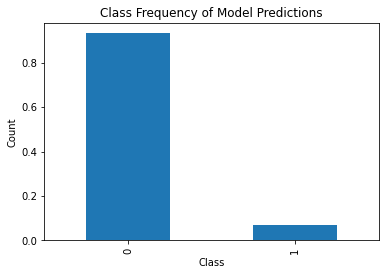

f1 score: 0.304


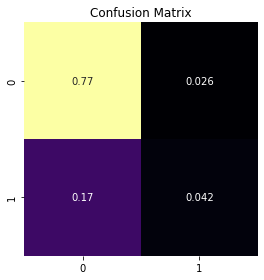

AUC-ROC value = 0.781

--------------

- MODEL:  LOGISTIC REGRESSION  -
- CLASS BALANCE:  BALANCED  -


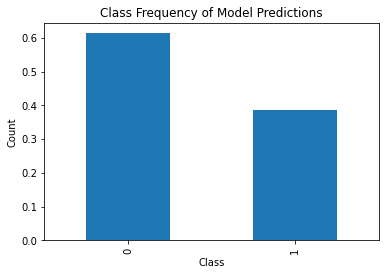

f1 score: 0.510


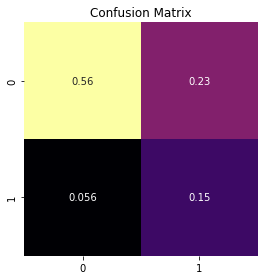

AUC-ROC value = 0.782


In [10]:
model = LogisticRegression(random_state=12345,solver='liblinear')
model_balanced = LogisticRegression(random_state=12345,class_weight='balanced',solver='liblinear')

display_class_balance(model,"LOGISTIC REGRESSION","NONE")
print("\n--------------\n")
display_class_balance(model_balanced,"LOGISTIC REGRESSION","BALANCED")

####  3.2 Decision Tree <a class="anchor" id="dt"></a>

- MODEL:  DECISION TREE  -
- CLASS BALANCE:  NONE  -


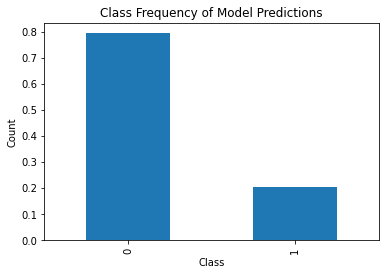

f1 score: 0.493


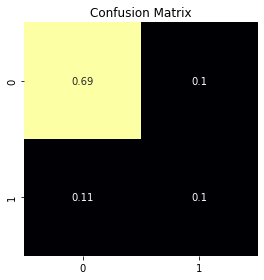

AUC-ROC value = 0.690

------------

- MODEL:  DECISION TREE  -
- CLASS BALANCE:  BALANCED  -


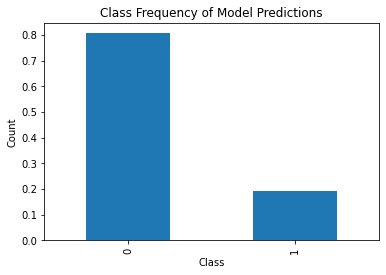

f1 score: 0.464


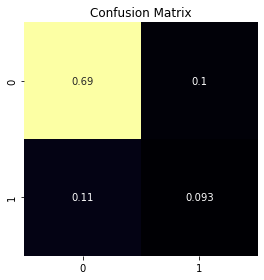

AUC-ROC value = 0.680


In [11]:
model = DecisionTreeClassifier(random_state=12345)
model_balanced = DecisionTreeClassifier(random_state=12345,class_weight='balanced')

display_class_balance(model,"DECISION TREE","NONE")
print("\n------------\n")
display_class_balance(model_balanced,"DECISION TREE","BALANCED")

#### 3.3 Random Forest <a class="anchor" id="rf"></a>

- MODEL:  RANDOM FOREST  -
- CLASS BALANCE:  NONE  -


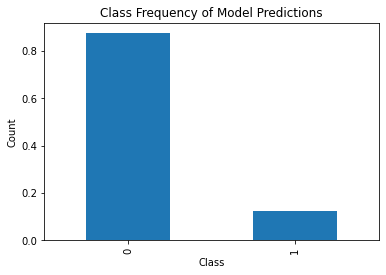

f1 score: 0.585


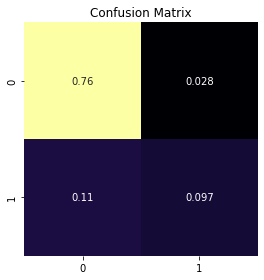

AUC-ROC value = 0.852

------------

- MODEL:  RANDOM FOREST  -
- CLASS BALANCE:  BALANCED  -


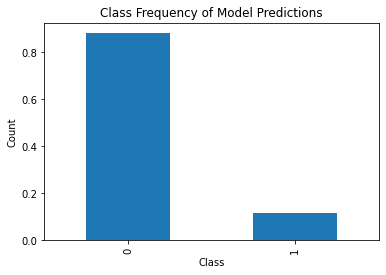

f1 score: 0.556


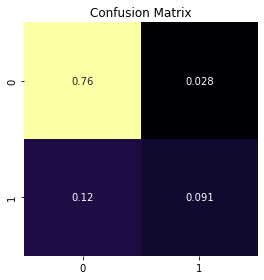

AUC-ROC value = 0.851


In [12]:
model = RandomForestClassifier(random_state=12345)
model_balanced = RandomForestClassifier(random_state=12345,class_weight='balanced')

display_class_balance(model,"RANDOM FOREST","NONE")
print("\n------------\n")
display_class_balance(model_balanced,"RANDOM FOREST","BALANCED")

In decision tree and random forest models, adding class balancing slightly negatively effected the model's score. The similar effect follows logically as the forest model includes decision trees. We can also see why the class balance does little in the confusion matrix of the compared models by the lack of change. In the logistic regression model adding class balance greatly increased the model's score. With the class balance, True Positives were greatly increased and False Negatives were decreased to improve recall and precision as seen in the confusion matrix. Overall the Random Forest model performed the best. Let's take a closer look at it's class probabilities:

#### 3.4 Threshold <a class="anchor" id="threshold"></a>

In [13]:
#random forest model with class balance
model = RandomForestClassifier(random_state=12345,class_weight='balanced').fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

print(probabilities_one_valid[:5])

[0.59 0.02 0.61 0.03 0.03]


Some class probabilities are low so we will try adjusting the threshold:

In [14]:
for threshold in np.arange(0.04, 0.15, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predictions_valid)

    print("Threshold = {:.3f} | F1 Score = {:.3f}".format(
        threshold, score))

Threshold = 0.040 | F1 Score = 0.556
Threshold = 0.050 | F1 Score = 0.556
Threshold = 0.060 | F1 Score = 0.556
Threshold = 0.070 | F1 Score = 0.556
Threshold = 0.080 | F1 Score = 0.556
Threshold = 0.090 | F1 Score = 0.556
Threshold = 0.100 | F1 Score = 0.556
Threshold = 0.110 | F1 Score = 0.556
Threshold = 0.120 | F1 Score = 0.556
Threshold = 0.130 | F1 Score = 0.556
Threshold = 0.140 | F1 Score = 0.556


Adjusting the threshold had no affect. The confusion matrix showed far more negative than positive so we will upsample, tuning the amount of repetitions.

#### 3.5 Upsample <a class="anchor" id="upsample"></a>

In [15]:
def upsample (features,target,repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return shuffle(features_upsampled,target_upsampled,random_state=12345)

for i in range(2,10):
    features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
    model = RandomForestClassifier(random_state=12345,class_weight='balanced').fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    score = f1_score(target_valid, predictions_valid)
    print("Upsample Repititions = {:.0f} | F1 Score = {:.3f}".format(
        i, score))

Upsample Repititions = 2 | F1 Score = 0.556
Upsample Repititions = 3 | F1 Score = 0.556
Upsample Repititions = 4 | F1 Score = 0.556
Upsample Repititions = 5 | F1 Score = 0.556
Upsample Repititions = 6 | F1 Score = 0.556
Upsample Repititions = 7 | F1 Score = 0.556
Upsample Repititions = 8 | F1 Score = 0.556
Upsample Repititions = 9 | F1 Score = 0.556


Adding upsamples did not effect the F1 score, so let's try downsampling.

####  3.6 Downsample <a class="anchor" id="downsample"></a>

In [16]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

for fraction in np.arange(0.1, 0.61, 0.1):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    model = RandomForestClassifier(random_state=12345,class_weight='balanced').fit(features_train, target_train)
    model.fit(features_downsampled,target_downsampled)
    predicted_valid= model.predict(features_valid)
    score = f1_score(target_valid, predictions_valid)
    print("Downsample Fractions = {:.1f} | F1 Score = {:.3f}".format(
        fraction, score))

Downsample Fractions = 0.1 | F1 Score = 0.556
Downsample Fractions = 0.2 | F1 Score = 0.556
Downsample Fractions = 0.3 | F1 Score = 0.556
Downsample Fractions = 0.4 | F1 Score = 0.556
Downsample Fractions = 0.5 | F1 Score = 0.556
Downsample Fractions = 0.6 | F1 Score = 0.556


Downsampling also had no affect on the F1 score of the model. We will try other upsampling and downsampling techniques.

#### 3.7 Tomek's Links <a class="anchor" id="tomek"></a>

Tomek's links are pairs of close instances of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. Tomek’s link exists if the two samples are the nearest neighbors of each other

In [17]:
tl = TomekLinks()

X_tl, y_tl = tl.fit_resample(features_train, target_train)

print('original target shape:', target_train.shape)
print('Resample target shape', y_tl.shape)

model = RandomForestClassifier(random_state=12345,class_weight='balanced').fit(X_tl, y_tl)
predicted_valid= model.predict(features_valid)
score = f1_score(target_valid, predictions_valid)
print("F1 Score = {:.3f}".format(score))

original target shape: (5454,)
Resample target shape (5180,)
F1 Score = 0.556


#### 3.8 SMOTE <a class="anchor" id="smote"></a>

Synthetic Minority Oversampling Technique works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [18]:
sm = SMOTE(random_state=12345)
X_sm, y_sm = sm.fit_resample(features_train, target_train)

print('original target shape:', target_train.shape)
print('Resample target shape', y_sm.shape)

model = RandomForestClassifier(random_state=12345,class_weight='balanced').fit(X_sm, y_sm)
predicted_valid= model.predict(features_valid)
score = f1_score(target_valid, predictions_valid)
print("F1 Score = {:.3f}".format(score))

original target shape: (5454,)
Resample target shape (8656,)
F1 Score = 0.556


Tomek's links and SMOTE had no impact on the F1 score.

### 4. Parameter Hypertuning <a class="anchor" id="pht"></a>

In [19]:
## hypertune model parameters with GridSearch
rf = RandomForestClassifier(random_state=12345,class_weight='balanced')

params = {
    'n_estimators': (100,110),
    'max_depth': (2,11),
    'min_samples_split': (2,11)
}

Grid_CBC = GridSearchCV(estimator=rf, scoring='f1',  param_grid=params,cv=3, verbose=True)
Grid_CBC.fit(features_train, target_train)

print("Best F1:",Grid_CBC.best_score_.round(4))
print("Best params: ",Grid_CBC.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best F1: 0.6036
Best params:  {'max_depth': 11, 'min_samples_split': 11, 'n_estimators': 110}


### 5. Model Test <a class="anchor" id="test"></a>

In [20]:
model = RandomForestClassifier(random_state=12345,class_weight='balanced',n_estimators=110,max_depth=11,min_samples_split=11)
model.fit(features_train, target_train)

predictions_train = model.predict(features_train)
score_train = f1_score(target_train, predictions_train)
print("F1 Score (train)= {:.3f}".format(score_train))

predictions_test = model.predict(features_test)
score = f1_score(target_test, predictions_test)
print("F1 Score (test)= {:.3f}".format(score))

F1 Score (train)= 0.820
F1 Score (test)= 0.610


The test yielded a F1 score higher than the 0.59 threshold, indicating a good performing prediction model according to our goal.

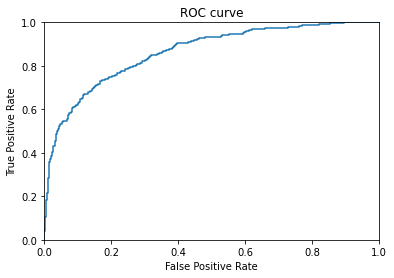

AUC-ROC value = 0.86


In [21]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show() 

auc_roc = roc_auc_score(target_test,probabilities_one_test)

print("AUC-ROC value = {:.2f}".format(auc_roc))

The AUC-ROC of .86 is far above the 0.5 of a random model, further indicating the validity of the model.

#### 5.1 Sanity Check <a class="anchor" id="sanity"></a>

The sanity check involves investigating how often the target contains the class "1" or "0", then comparing with the model's predictions.

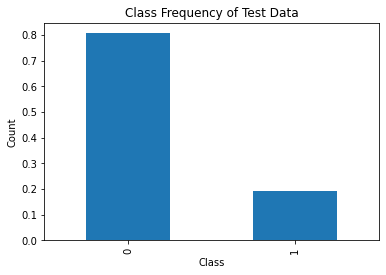

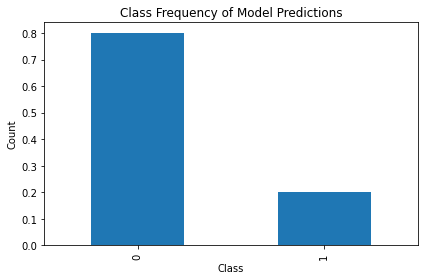

In [22]:
class_frequency_df = target_test.value_counts(normalize=True)
class_frequency_df.plot(kind='bar')
plt.title('Class Frequency of Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.figure()

predicted_test = pd.Series(model.predict(features_test))
class_frequency = predicted_test.value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.title('Class Frequency of Model Predictions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The comparison between class frequency of the test data and model predictions nearly identical.

## Conclusion <a class="anchor" id="end"></a>

Through careful preparation, model choice, and parameter tuning we have found a prediction model for bank customers that are a possible concern for exiting. This will enable the bank to focus efforts on these 'at risk' exiters in order to limit customer churn.